# Imports

In [1]:
import os
import numpy as np
import torchvision

import torch
import matplotlib.pyplot as plt

import pyro
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MNIST data loading

Data stored in ./data/MNIST

In [2]:
os.makedirs("data", exist_ok=True)

In [3]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [4]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit,
                torchvision.transforms.Lambda(lambd=torch.flatten)])

mnist_train = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root="data", download=True, transform=transform, train=False)

Sanity check for the data:

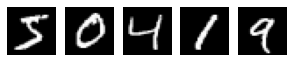

In [5]:
n_examples = 5
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(n_examples, 1))

for i in range(n_examples):
    axes[i].imshow(mnist_train.data[i], cmap="gray")
    axes[i].axis('off')

plt.show()

In [6]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [7]:
mnist_train.data[0].shape

torch.Size([28, 28])

In [8]:
d = 28
D = d ** 2

# RealNVP 

In [9]:
pyro_base_distribution = pyro.distributions.Normal(
    loc=torch.zeros((D,)).to(device),
    scale=torch.ones((D,)).to(device)
)

n_blocks = 5
blocks = []
for _ in range(n_blocks):
    blocks.append(
        pyro.distributions.transforms.affine_coupling(
            input_dim=D,
            hidden_dims=[D, D]
        ).to(device)
    )
    blocks.append(
        pyro.distributions.transforms.permute(
            input_dim=D,
            permutation=torch.from_numpy(np.random.permutation(D)).to(device)
        )
    )
    blocks.append(
        pyro.distributions.transforms.BatchNorm(
            input_dim=D
        ).to(device)
    )
    
pyro_transformed_distribution = pyro.distributions.TransformedDistribution(
    base_distribution=pyro_base_distribution,
    transforms=blocks
)

In [10]:
modules = torch.nn.ModuleList([b for i, b in enumerate(blocks) if i%3 != 1])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-4, weight_decay=1e-5)
n_epochs = 10

In [11]:
pbar = trange(n_epochs)
losses = []
for epoch in pbar:
    for x_batch, _ in trainloader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        loss = - pyro_transformed_distribution.log_prob(x_batch).mean()
        loss.backward()
        optimizer.step()

        pyro_transformed_distribution.clear_cache()
        
        pbar.set_postfix_str(f"loss = {loss.item():.3f}")
    losses.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
n_examples = 10
lambd = 1e-6
generated_images = (
    pyro_transformed_distribution
    .sample((n_examples,))
    .detach()
    .cpu()
)

generated_images = (torch.sigmoid(generated_images) - lambd) / (1 - 2 * lambd)

generated_images = (
    generated_images
    .view((n_examples, d, d))
    .numpy()
)

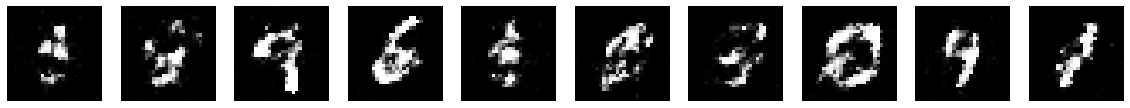

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(20, 40))

for i in range(n_examples):
    axes[i].imshow(generated_images[i], cmap="gray")
    axes[i].axis('off')

plt.show()